In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!nvidia-smi   //provides google colabs alloted machine specs

Mon Apr 25 07:35:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# from fastai import *
# import fastai
# Fastai is sort of a higher level API for PyTorch
from fastai.vision import open_image, open_mask, SegmentationLabelList, get_image_files, SegmentationItemList, get_transforms, Path, imagenet_stats, unet_learner, models, lr_find, DatasetType

from fastai.callbacks import  GeneralScheduler, TrainingPhase, EarlyStoppingCallback, SaveModelCallback
from fastai.callback import Callback, annealing_cos
# import glob
# from fastai.sgdr import *
# import cv2.imshow
from sklearn.metrics import fbeta_score   #for calculating f_score which is measure of accuracy
# from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
# import torchvision
# import zipfile
from PIL import Image
import numpy as np
import posixpath
import random

In [ ]:
# Checking if our device is CUDA enabled or not. Compute Unified Device Architecture enabled device means a program perform calculations using both the CPU and GPU.
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu");
print(device)

cuda:0


In [ ]:
# Connecting drive folder to our program. All testing, training and validation and their respective masks are stored here.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Defining 4 categories for multilabel classification
colors = np.loadtxt('/content/drive/MyDrive/Academics/Ml_project_cloth_seg/labels.txt',delimiter='\n',dtype=str);
colors

array(['Background', 'UpperBody', 'WholeBody', 'LowerBody'], dtype='<U10')

In [ ]:
# Images in our dataset will be shuffled randomly as batches are formed. This function is used for pseudo-random shuffling.
random.seed(4)

In [ ]:
path_images = "/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images/train"
path_valid = "/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images/val"
fnames = get_image_files(path_images)
fnames[:10]

[PosixPath('/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images/train/1401.png'),
 PosixPath('/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images/train/1402.png'),
 PosixPath('/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images/train/1403.png'),
 PosixPath('/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images/train/1404.png'),
 PosixPath('/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images/train/1405.png'),
 PosixPath('/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images/train/1406.png'),
 PosixPath('/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images/train/1407.png'),
 PosixPath('/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images/train/1409.png'),
 PosixPath('/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images/train/1408.png'),
 PosixPath('/content/drive/M

pathlib.PosixPath

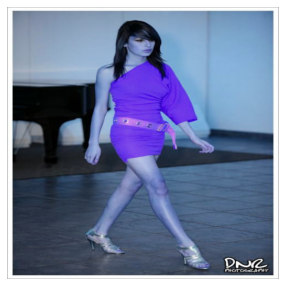

In [ ]:
# Loading 4th image from our training images database.
img_f = fnames[3]
img = open_image(img_f) 
#img_f is of type Posix_path
img.show(figsize=(5,5))
#type(img_f)

In [ ]:
# Here we are importing masks of training images
import posixpath
get_y_fn = lambda x: (posixpath.join('/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/masks/train',f'{x.stem}{x.suffix}')) if (x.parent.stem == 'train') else (posixpath.join('/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/masks/val',f'{x.stem}{x.suffix}'))
# get_y_fn=lambda x:path_lbl/f'{x.stem}_mask{x.suffix}'

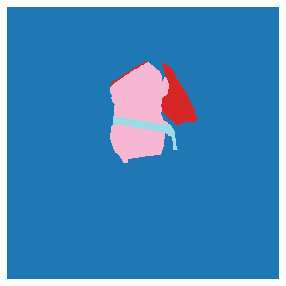

In [ ]:
# Masks are stored in .pil format
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
# It shows how many labels (out of 4) are present in image's mask...confirms that image has only 4 attributes.
np.unique(mask.data)

array([0, 1, 2, 3])

In [ ]:
# Following command shows image's mask as matrix, where each pixel is classified into 4 labels [0, 1, 2, 3]
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([512, 512]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [ ]:
class SegLabelListCustom(SegmentationLabelList):
        def open(self, fn): return open_mask(fn, div=False)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [ ]:
"""Run this for training as during training size is 1/2 nd testing size is same as original (480,640)"""
src = (SegItemListCustom.from_folder(Path('/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images'))
   .split_by_folder(train='train',valid='val') # Splitting by training set and validation set
   .label_from_func(get_y_fn, classes=colors)
   .transform(get_transforms(),tfm_y=True, size=src_size//2) # tfms_y=True because transforms we are applying on trainset, will be also applied on train_masks
   .add_test_folder(test_folder='test',tfms=None,tfm_y=False) # Since test_masks are empty we don't need tfms on ground truth here so tfm_y=False
   )

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


In [ ]:
# Characteristics of imported images (Training)
src.train.y

SegLabelListCustom (2400 items)
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images

In [ ]:
# Characteristics of imported images (Testing)
src.test

LabelList (303 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: /content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images

In [ ]:
# Data preparation: Since our model does not take raw images, we are flipping image horizontally, and downsampling it to half its size.
# tfms = get_transforms(do_flip=True,size=src_size//2)
data = (src
        .databunch(bs=8)
        .normalize(imagenet_stats))

In [ ]:
# All the attributes of our data: 2400 Training Images, 300 Validation Images, 303 Testing Images
data

ImageDataBunch;

Train: LabelList (2400 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images;

Valid: LabelList (300 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images;

Test: LabelList (303 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: /content/drive/MyD

In [ ]:
# data.train_ds[0][1].data
np.unique(data.train_ds[5][1].data)  # data is our object, data.train_ds[5][0] → Image, data.train_ds[5][1] → Image’s Mask, data.train_ds[5][1].data is then converted to numpy array and np.unique gives all the features(out of 4) present in image.
# data.valid_ds[0][1]
# data.valid_ds[0][0]

array([0, 1, 3])

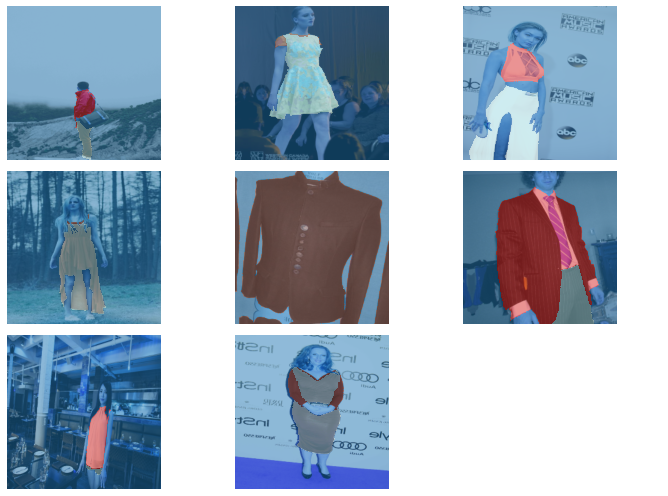

In [ ]:
# Displaying one batch (8 images) 
data.show_batch(figsize=(10,7)) 

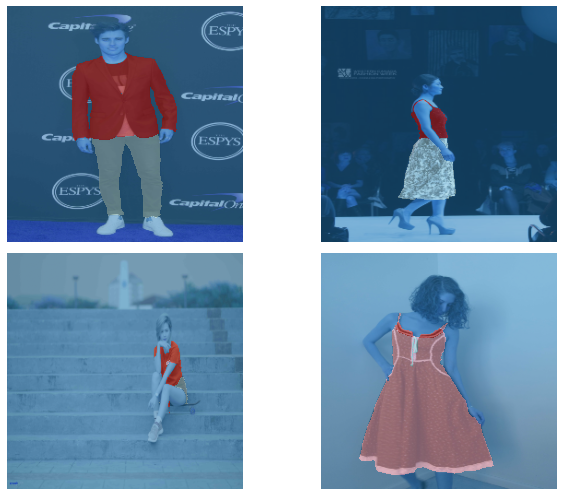

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [ ]:
# Categorical crossentropy is a loss function that is used in multi-class classification tasks.
class CELoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(CELoss,self).__init__()
        self.reduction=reduction    

    def forward(self, inputs, targets):
        CE_loss = torch.nn.CrossEntropyLoss(reduction=self.reduction)(inputs, targets.squeeze(1))
        return CE_loss    

In [ ]:
#Here, we are not penalizing models for the wrong detection of background, we are only focused on detecting the front, upper, and middle body.
name2id = {v:k for k,v in enumerate(colors)}
void_code = name2id['Background']
def accu2(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
accu2=accu2
loss_func1 = CELoss()
# Regularization parameter
wd= 1e-7 

In [ ]:
# We are using mini batch Stochastic Gradient Descent 
def fit_sgd_warm(learn,n_cycles,lr, mom, cycle_len, cycle_mult):
    n = len(learn.data.train_dl)
    phases = [(TrainingPhase(n * (cycle_len * cycle_mult**i))
                 .schedule_hp('lr', lr, anneal=annealing_cos)
                 .schedule_hp('mom', mom)) for i in range(n_cycles)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    if cycle_mult != 1:
        total_epochs = int(cycle_len * (1 - (cycle_mult)**n_cycles)/(1-cycle_mult)) 
    else: total_epochs = n_cycles * cycle_len
    # learn.fit(total_epochs)
    # Learning starts, if model accuracy is increased, it stores the model by default
    learn.fit(total_epochs,callbacks=[SaveModelCallback(learn, every='improvement', monitor='accu2', name='clothsegbestmodel2', mode='auto')])

In [ ]:
# Fine tuning RESNET50 model based on our requirements 
learn = unet_learner(data, models.resnet50, metrics=accu2, loss_func=loss_func1, wd=wd)

In [ ]:
# Showing all the hidden layers of our model
learn.load("/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images/models/clothsegbestmodel2")

Learner(data=ImageDataBunch;

Train: LabelList (2400 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images;

Valid: LabelList (300 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images;

Test: LabelList (303 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: /cont

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
fit_sgd_warm(learn,n_cycles=2,lr=1e-4,mom=0.9,cycle_len=1,cycle_mult=2) 

epoch,train_loss,valid_loss,accu2,time
0,0.166358,0.169998,0.774806,15:19


Better model found at epoch 0 with accu2 value: 0.7748061418533325.


In [ ]:
# learn.save("w2_clothssss") # Saves model in PyTorch format (.pth), kind of zip file

In [ ]:
learn.export() # .pkl file is required for our GUI 

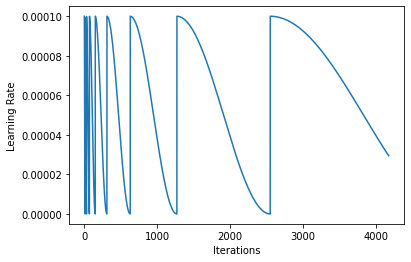

In [ ]:
learn.recorder.plot_lr()   #Cossine Anneling

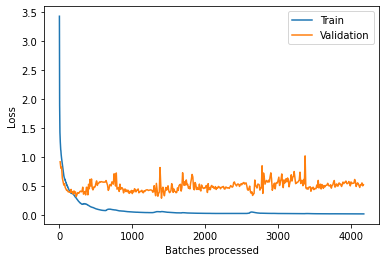

In [ ]:
learn.recorder.plot_losses()


In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


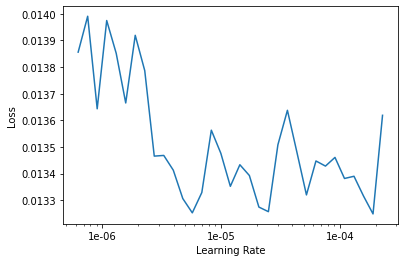

In [ ]:
#AFTER UNFREEZE AGAIN CHECK FOR LR
lr_find(learn)
learn.recorder.plot()

In [ ]:
fit_sgd_warm(learn,n_cycles=5,lr=1e-4,mom=0.9,cycle_len=1,cycle_mult=2)

epoch,train_loss,valid_loss,accu2,time
0,0.303894,0.530995,0.527469,00:24
1,0.255695,0.460704,0.366355,00:11
2,0.226821,0.354300,0.469499,00:11
3,0.195656,0.346076,0.636019,00:11
4,0.172786,0.235296,0.738350,00:11
5,0.154061,0.238218,0.738711,00:11
6,0.137278,0.239462,0.744167,00:11
7,0.124566,0.235365,0.772079,00:11
8,0.117194,0.210918,0.754871,00:11
9,0.112630,0.245276,0.704757,00:11
